In [127]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential

In [128]:
df = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape', usecols=['Sentence #','Word','Tag'])
print(df)

          Sentence #           Word Tag
0        Sentence: 1      Thousands   O
1                NaN             of   O
2                NaN  demonstrators   O
3                NaN           have   O
4                NaN        marched   O
...              ...            ...  ..
1048570          NaN           they   O
1048571          NaN      responded   O
1048572          NaN             to   O
1048573          NaN            the   O
1048574          NaN         attack   O

[1048575 rows x 3 columns]


## ```Data Cleaning```

Read in the dataset using pd.read_csv() and clean the dataset.

To avoid using very short or long sentences, select the ones with more than 15 and fewer than 30 words.

Split the data into training and validation sets.

In [129]:
# We fill Nan values using the previous value. 
# This way we can separate each sentence.
df.fillna(method='ffill', inplace=True)
print(df)
# Remove "Sentence: " from the sentence column
df['Sentence #'] = df['Sentence #'].str.replace('Sentence: ','').astype(int)
print(df)
# Set the index as the sentence number. Then we filter each sentence, joininig the text
df.set_index('Sentence #', inplace=True)
# Take a quick look at the dataset
df.head()

              Sentence #           Word Tag
0            Sentence: 1      Thousands   O
1            Sentence: 1             of   O
2            Sentence: 1  demonstrators   O
3            Sentence: 1           have   O
4            Sentence: 1        marched   O
...                  ...            ...  ..
1048570  Sentence: 47959           they   O
1048571  Sentence: 47959      responded   O
1048572  Sentence: 47959             to   O
1048573  Sentence: 47959            the   O
1048574  Sentence: 47959         attack   O

[1048575 rows x 3 columns]
         Sentence #           Word Tag
0                 1      Thousands   O
1                 1             of   O
2                 1  demonstrators   O
3                 1           have   O
4                 1        marched   O
...             ...            ...  ..
1048570       47959           they   O
1048571       47959      responded   O
1048572       47959             to   O
1048573       47959            the   O
1048574       4

,Word,Tag
Sentence #,,
1,Thousands,O
1,of,O
1,demonstrators,O
1,have,O
1,marched,O


In [130]:
# Filter the dataframe by sequence length
# As you can see from the head above, the index values are repeated hence we need to know all the unique indices in our dataframe.
# Each unique index represents a sentence number.
# We also want to find the length of each sentence in the dataframe hence we make use of the unique function.
index, length = np.unique(df.index, return_counts=True)
print(index)
print(length)
print(type(length))
# To avoid using long sentences, we are restricting length between 15 to 30 words
b1 = length>15
b2 = length<30

# We are using logical_and function because lets say if a sentence's length is greater than 15 and also greater than 30, we won't consider that sentence.
# For a sentence to be considered , both conditions must be true.
b = np.logical_and(b1, b2)
print(b)

# Taking sentences satisfying the condition.
index = index[b]
length = length[b]


# Constucting a dataframe out of valid sentences.
print(df)
df = df.loc[index]
print(index)
print(df)

[    1     2     3 ... 47957 47958 47959]
[24 30 14 ... 11 11  8]
<class 'numpy.ndarray'>
[ True False False ... False False False]
                     Word Tag
Sentence #                   
1               Thousands   O
1                      of   O
1           demonstrators   O
1                    have   O
1                 marched   O
...                   ...  ..
47959                they   O
47959           responded   O
47959                  to   O
47959                 the   O
47959              attack   O

[1048575 rows x 2 columns]
[    1     5     6 ... 47954 47955 47956]
                     Word Tag
Sentence #                   
1               Thousands   O
1                      of   O
1           demonstrators   O
1                    have   O
1                 marched   O
...                   ...  ..
47956                   a   O
47956              border   O
47956            security   O
47956             outpost   O
47956                   .   O

[653765 rows x 2 

In [131]:
# Helper code for train-test split
index = np.unique(df.index)

# Splitting sentences into training and test sets using index values.
# We are using random_state for reproducibility
train_index, val_index = train_test_split(index, train_size=0.8,random_state=0)

df_train = df.loc[train_index]
df_val = df.loc[val_index]

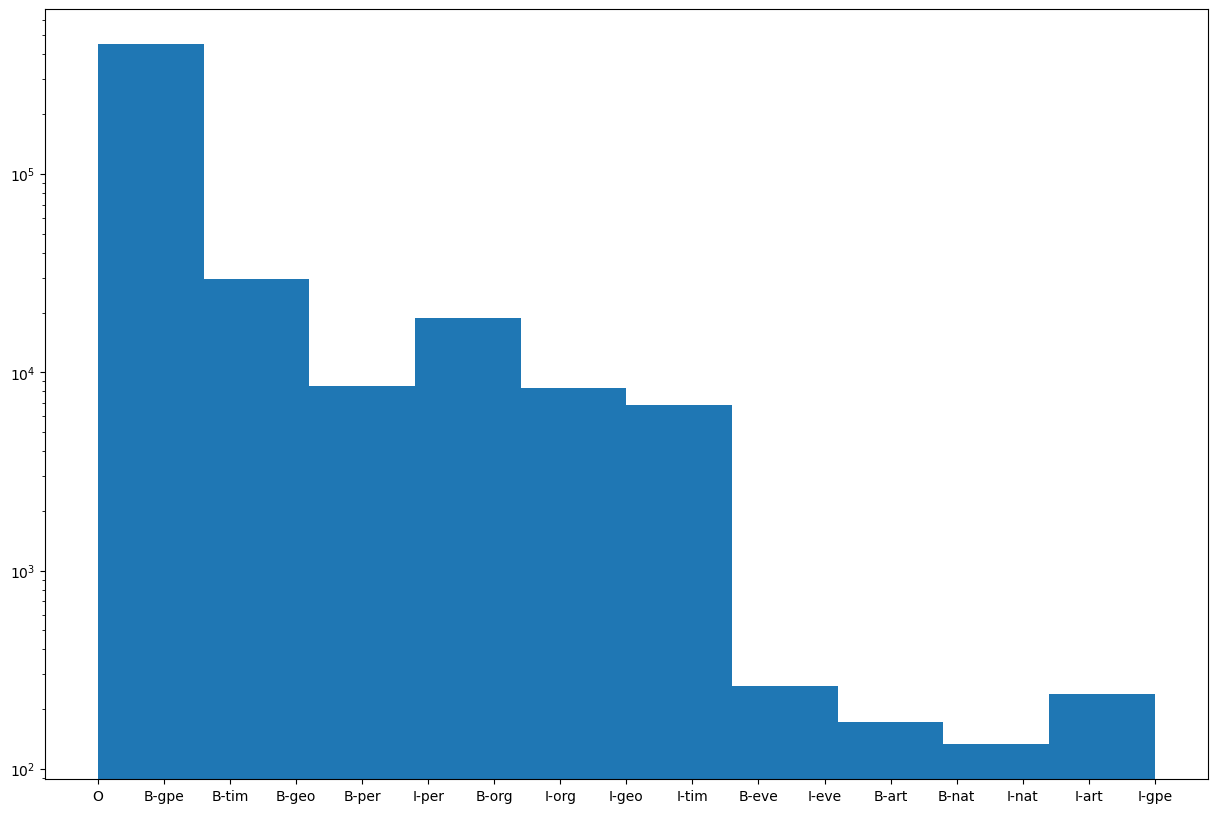

In [132]:
# Take a quick look at the different tags

plt.figure(figsize=(15,10))
plt.hist(df_train.Tag, log=True)
plt.show()

## ```Data Transformation```

* We know that words need to be transformed into numerical form. Transform the tags and words into numbers.

* Perform label encoding on the tags. 

* Remove non-alphanumeric characters from the word column in both the train and validation sets and replace them with an empty string.

* Tokenize the word column using tf.keras.preprocessing.text.Tokenizer with default parameters.

* After tokenization of the word column, remove empty elements from the tokens created.

* After doing the above steps, we will now create our training and validation data.

  * Create three lists:

    * A list of sentences, where each element is another list of all the tokens of the words in each sentence.

    * A list of tags, where each element is another list of all the tags corresponding to the words in each sentence extracted.

    * A list of to store the length of sentences.

  * Omit any sentence which only has a single element.

  * Ensure that the sentences are more than 15 and fewer than 30 words. Keep data points that satisfy this condition.

  * Post pad the sentences using `tf.keras.utils.pad_sequences()`.

In [133]:
import re
# Label encoding on the tags:
le = LabelEncoder()
le.fit(df_train['Tag'])
df_train['Tag'] = le.transform(df_train['Tag'])
df_val['Tag'] = le.transform(df_val['Tag'])

# remove non-alphabetic characters in Word column
def clean_text(text):
    text = re.sub('[^A-Za-z0-9]', '', text)
    return text
df_train['Word'] = df_train['Word'].apply(clean_text)
df_val['Word'] = df_val['Word'].apply(clean_text)
# tokenize the word column using keras tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_train['Word'])
df_train['Word'] = tokenizer.texts_to_sequences(df_train['Word'])
df_val['Word'] = tokenizer.texts_to_sequences(df_val['Word'])
print(df_train)

              Word  Tag
Sentence #             
9750           [1]   16
9750         [147]   16
9750        [2322]   16
9750        [3605]   16
9750        [2486]   16
...            ...  ...
4507         [513]   16
4507           [6]   16
4507        [5330]   16
4507        [2789]   16
4507            []   16

[523321 rows x 2 columns]


In [134]:
# remove empty sequences
df_train = df_train[df_train['Word'].map(len) > 0]
df_val = df_val[df_val['Word'].map(len) > 0]

# create training and validation data:
# 1st: list of lists of word tokens; 2ed: list of lists of tag tokens; 3rd: list of sentence lengths
def createData(df, indexs):
    word_list = np.array([[val[0] for val in df['Word'].loc[index]] for index in indexs])
    tag_list = np.array([[val for val in df['Tag'].loc[index]] for index in indexs])
    length_list = np.array([len(val) for val in word_list])
    # ensure sentences lengths are between 15 and 30
    b1 = length_list>15
    b2 = length_list<30
    b = np.logical_and(b1, b2)
    word_list = word_list[b]
    tag_list = tag_list[b]
    length_list = length_list[b]
    # pad sequences using keras.utils.pad_sequences
    word_list = tf.keras.preprocessing.sequence.pad_sequences(word_list, padding='post')
    tag_list = tf.keras.preprocessing.sequence.pad_sequences(tag_list, padding='post')
    return word_list, tag_list, length_list
word_train, tag_train, length_train = createData(df_train, train_index)
word_val, tag_val, length_val = createData(df_val, val_index)

    

/var/folders/dp/m3tcrtn96xs17l0rtk490mg00000gn/T/ipykernel_14401/4177708169.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  word_list = np.array([[val[0] for val in df['Word'].loc[index]] for index in indexs])
/var/folders/dp/m3tcrtn96xs17l0rtk490mg00000gn/T/ipykernel_14401/4177708169.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tag_list = np.array([[val for val in df['Tag'].loc[index]] for index in indexs])


In [135]:
df_train.head()

,Word,Tag
Sentence #,,
9750,[1],16
9750,[147],16
9750,[2322],16
9750,[3605],16
9750,[2486],16


In [136]:
print(tag_val[:2])
print(word_val[:2])
print(tag_train[:2])
print(word_train[:2])

[[ 2 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16  0  0  0  0  0
   0  0  0  0]
 [16 16 16 16 16 16 16 16 16 16 16 16 16 16 16  7  0  0  0  0  0  0  0  0
   0  0  0  0]]
[[  106   194  1514   141  6457  3232     5   105   318     6 15874  4172
     13  3421   810   384   141     3   211     0     0     0     0     0
      0     0     0     0]
 [   48    28    20     1   359    18   601   396    14    30   287     2
      1    88     3    67     0     0     0     0     0     0     0     0
      0     0     0     0]]
[[16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16  0
   0  0  0  0]
 [16  3 16 16 16 16 16 16  7 16 16  2 16 16 16 16 16 16 16  3  6 14 14 14
   0  0  0  0]]
[[    1   147  2322  3605  2486    70     8     1   116     6   514    12
     26   153  2678 13078  1842     6   299     4   789   180   110     0
      0     0     0     0]
 [    1   419   123    18   286     4  6148     5  1757   669     4   501
     64   340    43   445     5   185    1

## RNN models

* Create 4 many-to-many models with different values of h = [8,16,32].

  * A single-layer RNN network.

  * A k-layer RNN network, where k=[2,3]

  * A bidirectional single-layer RNN. 

  * A bidirectional k-layer RNN, where k=[2,3]

* In each model, 

  * The first layer should be Embedding, with mask_zero=True. This will propagate the mask in the network.

  * Then, SimpleRNN layers as required by the model. Remember to set return_sequences=True so as to build a many-to-many RNN models. 

  * For the bidirectional RNNs, remember to set go_backwards=True for the backward RNN and ensure to concatenate the hidden layers in the bidirectional RNN as needed.

  * Define a dense layer, with size set as the number of classes and activation softmax.

  * Note that the loss function to be used after label encoding is `sparse_categorical_crossentropy`.

  * The metric to be used is accuracy.

In [137]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 5))
input_Dim = len(tokenizer.word_index)+1
h_selections = [8, 16, 32]
k_selections = [1, 2, 3]
# Create k-layer RNN network (non-bidirectional) with h hidden units in each layer):
for h in h_selections:
    for k in k_selections:
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Embedding(input_dim=input_Dim, output_dim=h, mask_zero=True))
        for i in range(k):
            model.add(tf.keras.layers.SimpleRNN(h, return_sequences=True))
        model.add(tf.keras.layers.Dense(len(le.classes_), activation='softmax'))
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        #ini_loss, ini_acc = model.evaluate(word_val, tag_val, verbose=0)
        history = model.fit(word_train, tag_train, epochs=20, batch_size=128, validation_data=(word_val, tag_val))
        val_loss = history.history['val_loss']
        #val_loss.insert(0, ini_loss)
        val_acc = history.history['val_accuracy']
        #val_acc.insert(0, ini_acc)
        ax1.plot(range(20), val_loss, label=f'{h}_{k}_False')
        ax2.plot(range(20), val_acc, label=f'{h}_{k}_False')
# Create k-layer bidirectional RNN network with h hidden units in each layer):
for h in h_selections:
    for k in k_selections:
        inputs = tf.keras.layers.Input(shape=(None,))
        embedding = tf.keras.layers.Embedding(input_dim=input_Dim, output_dim=h, mask_zero=True)(inputs) 
        RNN_both = embedding
        for k in range(k):
            forward_RNN = tf.keras.layers.SimpleRNN(h, return_sequences=True)
            backward_RNN = tf.keras.layers.SimpleRNN(h, return_sequences=True, go_backwards=True)
            RNN_both = tf.keras.layers.Bidirectional(forward_RNN, backward_layer=backward_RNN)(RNN_both)
        concat = tf.keras.layers.Concatenate()([RNN_both, embedding])
        output = tf.keras.layers.Dense(len(le.classes_), activation='softmax')(concat)
        model = tf.keras.Model(inputs=inputs, outputs=output)
        #ini_loss, ini_acc = model.evaluate(word_val, tag_val, verbose=0)
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(word_train, tag_train, epochs=20, batch_size=128, validation_data=(word_val, tag_val))
        val_loss = history.history['val_loss']
        #val_loss.insert(0, ini_loss)
        val_acc = history.history['val_accuracy']
        #val_acc.insert(0, ini_acc)
        ax1.plot(range(20), val_loss, label=f'{h}_{k}_True')
        ax2.plot(range(20), val_acc, label=f'{h}_{k}_True')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy') 
ax1.legend()
ax2.legend()
ax1.set_title('Loss')
ax2.set_title('Accuracy')
plt.show()
        

Epoch 1/20
166/166 [==============================] - 3s 10ms/step - loss: 1.6602 - accuracy: 0.7789 - val_loss: 0.9818 - val_accuracy: 0.8365
Epoch 2/20
166/166 [==============================] - 2s 11ms/step - loss: 0.8971 - accuracy: 0.8309 - val_loss: 0.8166 - val_accuracy: 0.8365
Epoch 3/20
166/166 [==============================] - 1s 7ms/step - loss: 0.7885 - accuracy: 0.8312 - val_loss: 0.7012 - val_accuracy: 0.8391
Epoch 4/20
166/166 [==============================] - 1s 8ms/step - loss: 0.6375 - accuracy: 0.8415 - val_loss: 0.5478 - val_accuracy: 0.8596
Epoch 5/20
166/166 [==============================] - 1s 7ms/step - loss: 0.5214 - accuracy: 0.8644 - val_loss: 0.4672 - val_accuracy: 0.8783
Epoch 6/20
166/166 [==============================] - 1s 7ms/step - loss: 0.4512 - accuracy: 0.8807 - val_loss: 0.4084 - val_accuracy: 0.8986
Epoch 7/20
166/166 [==============================] - 1s 7ms/step - loss: 0.3933 - accuracy: 0.9049 - val_loss: 0.3564 - val_accuracy: 0.9177
Epoc

In [ ]:
# Create models

def make_model(hidden_size, layers, bidir = False):
    tf.keras.backend.clear_session()
    sentence_input1 = tf.keras.Input(shape=(None,), name='sentence_input')

    word_embedding = tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=hidden_size, name='word_embedding', mask_zero=True)
    masked_embeddinbg = word_embedding(sentence_input1)

    h_f = []
    h_b = []
    # First Forward RNN layer
    RNN = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
    hf = RNN(masked_embeddinbg)
    h_f.append(hf)
    if bidir:
        RNN = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True, go_backwards=True)
        hb = RNN(masked_embeddinbg)
        h_b.append(hb)


    # Create forward RNNs
    for k in range(1,layers):
        RNN_f = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
        hf = RNN_f(hf)
        h_f.append(hf)

        if bidir:
            RNN_b = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True, go_backwards=True)
            hb = RNN_b(hb)
            h_b.append(hb)

    if bidir:
        if layers==1:
            h = tf.keras.layers.concatenate([hf, hb])
        else:
            h = tf.keras.layers.concatenate(h_f+h_b)
    else:
        if layers==1:
            h = h_f[0]
        else:
            h = tf.keras.layers.concatenate(h_f)


    dense = tf.keras.layers.Dense(le.classes_.shape[0], activation='softmax', )
    output = dense(h)

    model = tf.keras.Model(inputs=sentence_input1, outputs=output, name='_'.join([str(hidden_size), str(layers),str(bidir)]))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = 'accuracy')
    return model